In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fast_ai_exp/rapid_image_classifier/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!wget https://chromedriver.storage.googleapis.com/79.0.3945.36/chromedriver_linux64.zip
!unzip chromedriver_linux64.zip
!mkdir /usr/bin/chromedriver
!mv chromedriver /usr/bin/chromedriver
!chown root:root /usr/bin/chromedriver
!chmod +x /usr/bin/chromedriver
!curl -sS -o - https://dl-ssl.google.com/linux/linux_signing_key.pub | apt-key add
!echo "deb [arch=amd64]  http://dl.google.com/linux/chrome/deb/ stable main" >> /etc/apt/sources.list.d/google-chrome.list
!apt-get -y update
!apt-get -y install google-chrome-stable

--2019-12-30 15:13:08--  https://chromedriver.storage.googleapis.com/79.0.3945.36/chromedriver_linux64.zip
Resolving chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c01::80
Connecting to chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4875160 (4.6M) [application/zip]
Saving to: ‘chromedriver_linux64.zip’

chromedriver_linux6 100%[===================>]   4.65M  --.-KB/s    in 0.03s   

2019-12-30 15:13:08 (138 MB/s) - ‘chromedriver_linux64.zip’ saved [4875160/4875160]

Archive:  chromedriver_linux64.zip
  inflating: chromedriver            
OK
Ign:1 http://dl.google.com/linux/chrome/deb stable InRelease
Get:2 http://dl.google.com/linux/chrome/deb stable Release [943 B]
Get:3 http://dl.google.com/linux/chrome/deb stable Release.gpg [819 B]
Get:4 http://dl.google.com/linux/chrome/deb stable/main amd64 Packages [1,0

In [3]:
from fastai import *
from fastai.vision import *
import PIL
!pip install google_images_download
from google_images_download import google_images_download

     |████████████████████████████████| 911kB 4.2MB/s 
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=14550 sha256=faedb9faa92cb7c84947745111078c6cad48bce7fc851d5474d321659fbce7bb
  Stored in directory: /root/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


Declare main path, number of images to download, keywords for categories (Each keyword represents a category, more words, more categories) and which model to use in transfer learning

In [0]:
PATH = 'images'
number_of_images = 100
keywords = "cat, dog"
tl_model = models.resnet34

setup args for downloader

In [13]:
downloader = google_images_download.googleimagesdownload()
args = {
    "keywords": keywords,
    "limit": number_of_images,
    "print_urls": False,
    "output_directory": "{}/train".format(PATH),
    "chromedriver":"/usr/bin/chromedriver/chromedriver"
}

paths = downloader.download(args)


Item no.: 1 --> Item name = cat
Evaluating...
Starting Download...
Completed Image ====> 1.Thinking-of-getting-a-cat.png
Completed Image ====> 2.cat-10-e1573844975155.jpg
Completed Image ====> 3.An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg
Completed Image ====> 4.6NJIVWVGRZEERA46BKCCS3UY2E.jpg
Completed Image ====> 5.Cat_poster_1.jpg
Completed Image ====> 6.istock-1069317442.jpg
Completed Image ====> 7.Layer-1704-1920x840.jpg
Completed Image ====> 8._110198706_capture.jpg
Completed Image ====> 9.1200px-Cat03.jpg
Completed Image ====> 10.cat-217679.jpg
Completed Image ====> 11.191024091949-02-foster-cat-large-169.jpg
Completed Image ====> 12.5dcc613f1f00009304dee539.jpeg
Completed Image ====> 13.02-cat-training-NationalGeographic_1484324.jpg
Completed Image ====> 14.img_1317.jpg
Completed Image ====> 15.maxresdefault.jpg
Completed Image ====> 16.Transparent-OrangeWhiteCat.png
Completed Image ====> 17.b23f78ae-5321-40ec-aa25-dfce9e639ddd-Liberty.jpg
Completed I

define functions for image validation and creation of validation sets

In [0]:
def validate_images(path):
  invalid_images = []
  for class_img in os.listdir(path):
    for img in os.listdir('{}/{}'.format(path, class_img)):
      try:
        img = PIL.Image.open('{}/{}/{}'.format(path, class_img, img))
        img.verify()
      except (IOError, SyntaxError, Exception) as error:
        print('{}/{}/{}'.format(path, class_img, img) + ' - Not good')
        invalid_images.append('{}/{}/{}'.format(path, class_img, img))
  return invalid_images


def create_validation_set(path, validation_count):
  if not os.path.exists('{}/valid'.format(path)):
    os.makedirs('{}/valid'.format(path))
  for image_class in os.listdir('{}/train'.format(path)):
    if not os.path.exists('{}/valid/{}'.format(path, image_class)):
      os.makedirs('{}/valid/{}'.format(path, image_class))
    for image in random.sample(os.listdir('{}/train/{}'.format(path, image_class)), validation_count):
      os.rename('{}/train/{}/{}'.format(path, image_class, image), 
                '{}/valid/{}/{}'.format(path, image_class, image))
      


In [0]:
for bad_image in validate_images('{}/train'.format(PATH)):
  os.remove(bad_image)

In [0]:
create_validation_set(PATH, 20)

In [21]:
classification_data = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=224)
classification_data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (149 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
 dog, dog, dog, dog, dog
Path: images;

Valid: LabelList (95 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
 dog, dog, dog, dog, dog
Path: images;

Test: None

In [22]:
learn = cnn_learner(classification_data, tl_model, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 180MB/s]


In [23]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.114288,1.210260,0.515789,00:16
1,0.662044,0.983822,0.326316,00:13
2,0.458144,0.509867,0.126316,00:13
3,0.372210,0.354792,0.042105,00:12


In [0]:
learn.save('first_run')

In [25]:
interpret = ClassificationInterpretation.from_learner(learn)

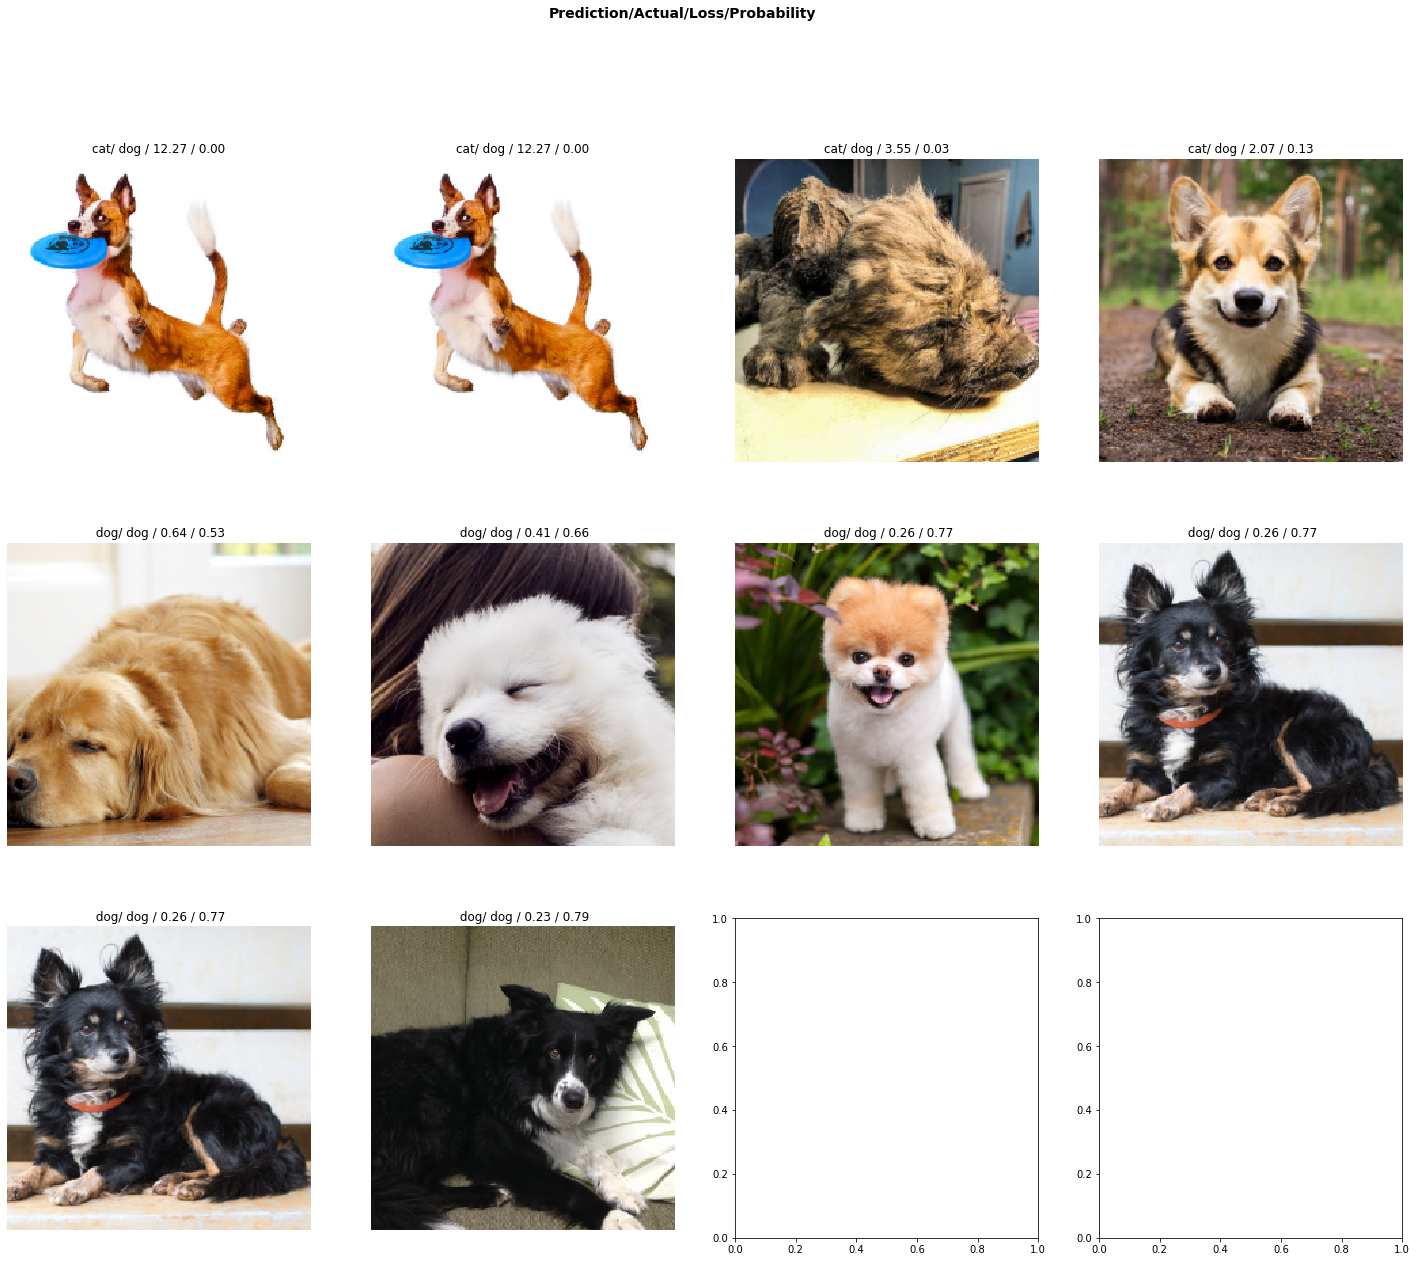

In [26]:
interpret.plot_top_losses(10, figsize=(25, 20))

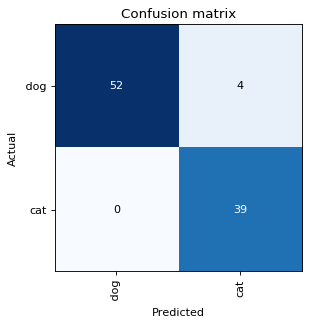

In [27]:
interpret.plot_confusion_matrix(figsize=(4, 4), dpi=80)

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 1.00E-04


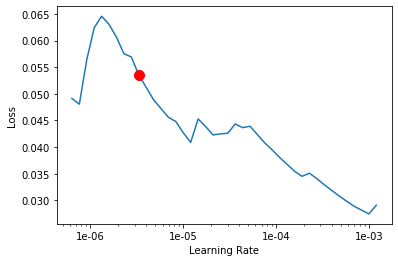

In [29]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_gradient_lrn_rate = learn.recorder.min_grad_lr

In [30]:
learn.fit_one_cycle(2, min_gradient_lrn_rate)

epoch,train_loss,valid_loss,error_rate,time
0,0.031736,0.271576,0.042105,00:14
1,0.036008,0.223786,0.031579,00:14


In [31]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.030683,0.199695,0.031579,00:14
1,0.057838,0.180399,0.021053,00:13
2,0.049838,0.161357,0.021053,00:13
3,0.044363,0.150743,0.021053,00:13


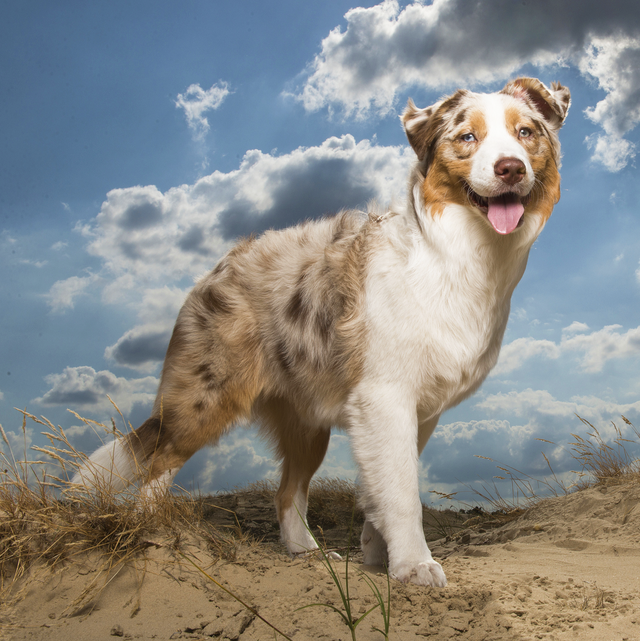

In [32]:
img = open_image('/content/gdrive/My Drive/fast_ai_exp/rapid_image_classifier/pup.png')
img

In [33]:
learn.predict(img)

(Category  dog, tensor(0), tensor([0.9921, 0.0079]))

In [0]:
learn.save(base_dir + 'dog_cat_model')